# Heart Disease Classification

The aim of this project is to predict the presence of heart disease in the patient using Decision Tree.

Variables included in the dataset :


|Variable     |Explanation|
|-------------|-----------|
|age           | Age in years|
|sex           | sex (1 = male; 0 = female)|
|cp            | chest pain type|
|trestbps      | resting blood pressure (in mm Hg on admission to the hospital)|
|chol          | serum cholestoral in mg/dl|
|fbs           | (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)|
|restecg       | resting electrocardiographic results|
|thalach       | maximum heart rate achieved|
|exang         | exercise induced angina (1 = yes; 0 = no)|
|oldpeak       | ST depression induced by exercise relative to rest|
|slope         | the slope of the peak exercise ST segment|
|ca            | number of major vessels (0-3) colored by flourosopy|
|thal          | 3 = normal; 6 = fixed defect; 7 = reversable defect|
|condition     | 0 = no disease, 1 = disease|

Dataset source: https://www.kaggle.com/datasets/cherngs/heart-disease-cleveland-uci?resource=download

## Project Preparation

Import libraries

In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import stats
from sklearn.metrics import (accuracy_score, auc, 
                             classification_report, confusion_matrix, 
                             ConfusionMatrixDisplay, PrecisionRecallDisplay, 
                             roc_curve)
from sklearn.model_selection import (cross_val_score, RandomizedSearchCV, 
                                     train_test_split)
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

Load the dataset

In [2]:
df = pd.read_csv("dataset/heart_disease.csv")
df.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   69    1   0       160   234    1        2      131      0      0.1      1   
1   69    0   0       140   239    0        0      151      0      1.8      0   
2   66    0   0       150   226    0        0      114      0      2.6      2   
3   65    1   0       138   282    1        2      174      0      1.4      1   
4   64    1   0       110   211    0        2      144      1      1.8      1   

   ca  thal  condition  
0   1     0          0  
1   2     0          0  
2   0     0          0  
3   1     0          1  
4   0     0          0

Keep the feature and target name

In [3]:
feature_names = df.columns[0:13].to_list()
class_name = ['no disease', 'disease']

## Data Summarization and Visualization

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB


Generate the descriptive statistic of the dataset

In [5]:
df.describe()

age         sex          cp    trestbps        chol         fbs  \
count  297.000000  297.000000  297.000000  297.000000  297.000000  297.000000   
mean    54.542088    0.676768    2.158249  131.693603  247.350168    0.144781   
std      9.049736    0.468500    0.964859   17.762806   51.997583    0.352474   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     48.000000    0.000000    2.000000  120.000000  211.000000    0.000000   
50%     56.000000    1.000000    2.000000  130.000000  243.000000    0.000000   
75%     61.000000    1.000000    3.000000  140.000000  276.000000    0.000000   
max     77.000000    1.000000    3.000000  200.000000  564.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  297.000000  297.000000  297.000000  297.000000  297.000000  297.000000   
mean     0.996633  149.599327    0.326599    1.055556    0.602694    0.676768   
std      0.994914   22.941562    0.469761    1.166123    0.618187    0.938965   
min      0.000000   71.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000  133.000000    0.000000    0.000000    0.000000    0.000000   
50%      1.000000  153.000000    0.000000    0.800000    1.000000    0.000000   
75%      2.000000  166.000000    1.000000    1.600000    1.000000    1.000000   
max      2.000000  202.000000    1.000000    6.200000    2.000000    3.000000   

             thal   condition  
count  297.000000  297.000000  
mean     0.835017    0.461279  
std      0.956690    0.499340  
min      0.000000    0.000000  
25%      0.000000    0.000000  
50%      0.000000    0.000000  
75%      2.000000    1.000000  
max      2.000000    1.000000

Show the class distribution

In [6]:
class_dist = df.groupby("condition").size()

for index, val in class_dist.items():
    percentage = (val / sum(class_dist) * 100)
    print(f"Class {index} : {val} samples ({percentage:.2f}%)")

Class 0 : 160 samples (53.87%)
Class 1 : 137 samples (46.13%)


Calculate the Pearson's correlation of each variables

In [7]:
df.corr()

age       sex        cp  trestbps      chol       fbs  \
age        1.000000 -0.092399  0.110471  0.290476  0.202644  0.132062   
sex       -0.092399  1.000000  0.008908 -0.066340 -0.198089  0.038850   
cp         0.110471  0.008908  1.000000 -0.036980  0.072088 -0.057663   
trestbps   0.290476 -0.066340 -0.036980  1.000000  0.131536  0.180860   
chol       0.202644 -0.198089  0.072088  0.131536  1.000000  0.012708   
fbs        0.132062  0.038850 -0.057663  0.180860  0.012708  1.000000   
restecg    0.149917  0.033897  0.063905  0.149242  0.165046  0.068831   
thalach   -0.394563 -0.060496 -0.339308 -0.049108 -0.000075 -0.007842   
exang      0.096489  0.143581  0.377525  0.066691  0.059339 -0.000893   
oldpeak    0.197123  0.106567  0.203244  0.191243  0.038596  0.008311   
slope      0.159405  0.033345  0.151079  0.121172 -0.009215  0.047819   
ca         0.362210  0.091925  0.235644  0.097954  0.115945  0.152086   
thal       0.120795  0.370556  0.266275  0.130612  0.023441  0.051038   
condition  0.227075  0.278467  0.408945  0.153490  0.080285  0.003167   

            restecg   thalach     exang   oldpeak     slope        ca  \
age        0.149917 -0.394563  0.096489  0.197123  0.159405  0.362210   
sex        0.033897 -0.060496  0.143581  0.106567  0.033345  0.091925   
cp         0.063905 -0.339308  0.377525  0.203244  0.151079  0.235644   
trestbps   0.149242 -0.049108  0.066691  0.191243  0.121172  0.097954   
chol       0.165046 -0.000075  0.059339  0.038596 -0.009215  0.115945   
fbs        0.068831 -0.007842 -0.000893  0.008311  0.047819  0.152086   
restecg    1.000000 -0.072290  0.081874  0.113726  0.135141  0.129021   
thalach   -0.072290  1.000000 -0.384368 -0.347640 -0.389307 -0.268727   
exang      0.081874 -0.384368  1.000000  0.289310  0.250572  0.148232   
oldpeak    0.113726 -0.347640  0.289310  1.000000  0.579037  0.294452   
slope      0.135141 -0.389307  0.250572  0.579037  1.000000  0.109761   
ca         0.129021 -0.268727  0.148232  0.294452  0.109761  1.000000   
thal       0.013612 -0.258386  0.323268  0.336809  0.260096  0.248825   
condition  0.166343 -0.423817  0.421355  0.424052  0.333049  0.463189   

               thal  condition  
age        0.120795   0.227075  
sex        0.370556   0.278467  
cp         0.266275   0.408945  
trestbps   0.130612   0.153490  
chol       0.023441   0.080285  
fbs        0.051038   0.003167  
restecg    0.013612   0.166343  
thalach   -0.258386  -0.423817  
exang      0.323268   0.421355  
oldpeak    0.336809   0.424052  
slope      0.260096   0.333049  
ca         0.248825   0.463189  
thal       1.000000   0.520516  
condition  0.520516   1.000000

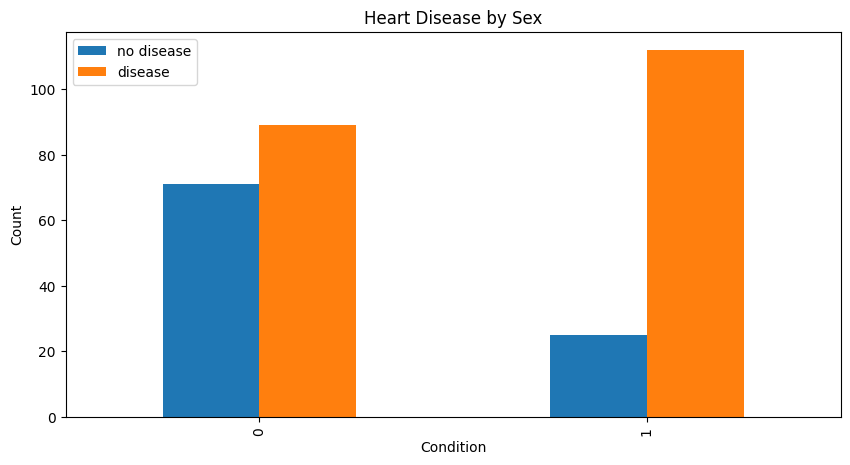

In [8]:
pd.crosstab(df.condition, df.sex).plot(kind ="bar", figsize = (10,5))
plt.title("Heart Disease by Sex")
plt.xlabel("Condition")
plt.ylabel("Count")
plt.legend(labels=class_name)
plt.show()

## Data Preparation

Split dataset into independent and dependent variables

In [9]:
X = df.drop(["condition"], axis=1)
y = pd.DataFrame(df["condition"]).copy()

Keep the class and feature names

Split training and testing data

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

Scale the independent variable using StandardScaler

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## Model Training

Build the classifier models

In [12]:
decision_tree = DecisionTreeClassifier(random_state=42)

In [13]:
param_dist = {"max_depth": [3, None],
              "max_features": stats.randint(1, 9),
              "min_samples_leaf": stats.randint(1, 9),
              "criterion": ["gini", "entropy"]}

In [14]:
clf_rscv = RandomizedSearchCV(decision_tree, param_dist, n_iter=50, cv=5, random_state=42)
clf_rscv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=50,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000239B9AA0850>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000239B9AD7F10>},
                   random_state=42)

In [15]:
clf = clf_rscv.best_estimator_

Check the accuracy on the training set

In [16]:
y_train_predicted = clf.predict(X_train)
print(f'Accuracy on Training Set: {accuracy_score(y_train, y_train_predicted):.2f}')

Accuracy on Training Set: 0.88


Perform a 10-fold-cross-validation

In [17]:
scores = cross_val_score(clf, X_train, y_train, cv=10)
print("10-fold-cross-validation accuracy: {:.2f}".format(scores.mean()))

10-fold-cross-validation accuracy: 0.86


In [18]:
print(classification_report(y_train, y_train_predicted))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       128
           1       0.88      0.86      0.87       109

    accuracy                           0.88       237
   macro avg       0.88      0.88      0.88       237
weighted avg       0.88      0.88      0.88       237



## Model Evaluation

Predict the testing set

In [19]:
y_test_predicted = clf.predict(X_test)
print(f'Accuracy on Testing Set: {accuracy_score(y_test, y_test_predicted):.2f}')

Accuracy on Testing Set: 0.68


Display the classification report of the testing set

In [20]:
print(classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       0.69      0.75      0.72        32
           1       0.68      0.61      0.64        28

    accuracy                           0.68        60
   macro avg       0.68      0.68      0.68        60
weighted avg       0.68      0.68      0.68        60



Create confusion matrix for testing set

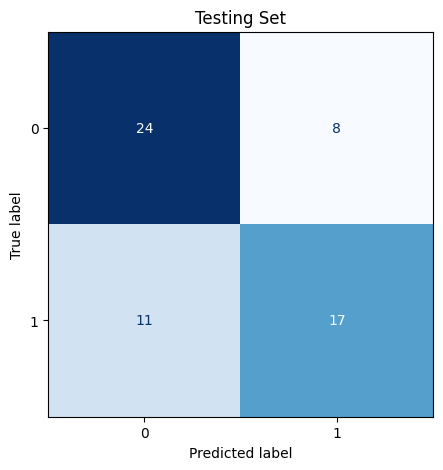

In [21]:
conf_mat_train = ConfusionMatrixDisplay(confusion_matrix(y_true=y_test, y_pred=y_test_predicted))

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title('Testing Set')
conf_mat_train.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False);

Plot the precision-recall curve

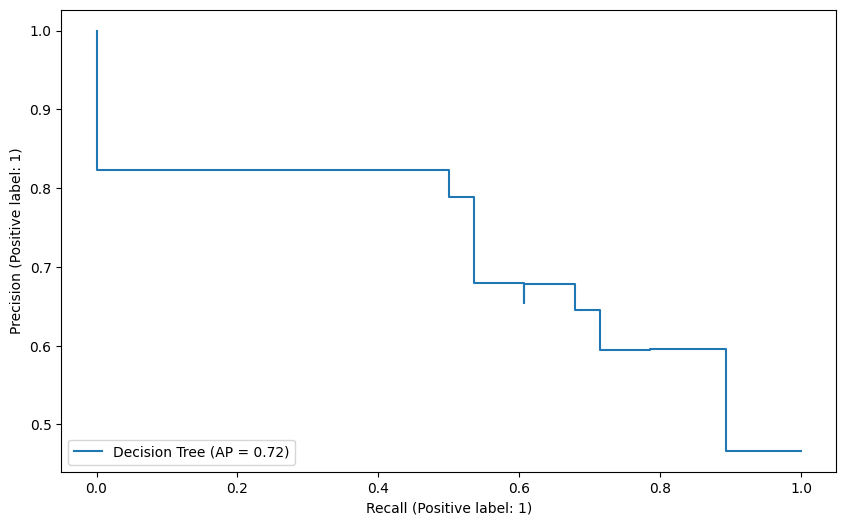

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
display = PrecisionRecallDisplay.from_estimator(
    clf, X_test, y_test, name="Decision Tree", ax=ax
)

Check models performance on testing set by accuracy and ROC AUC scores

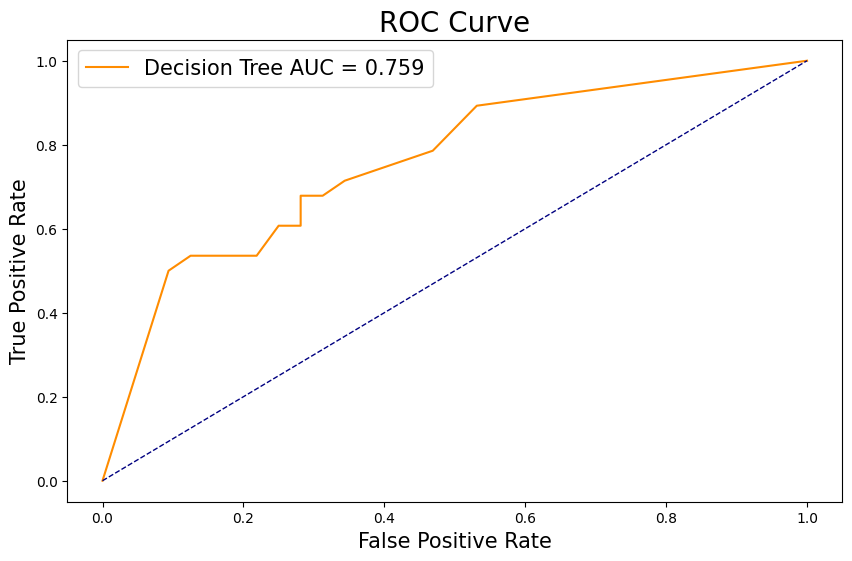

In [23]:
clf_proba = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, clf_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"Decision Tree AUC = {roc_auc:.3f}", color="darkorange")
plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
plt.title("ROC Curve", fontsize=20)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.legend(fontsize=15)
plt.show()

Visualize the decision tree

In [24]:
text_report = export_text(clf, feature_names=feature_names)
print(text_report)

|--- thal <= -0.34
|   |--- ca <= -0.17
|   |   |--- thalach <= 0.52
|   |   |   |--- trestbps <= 0.92
|   |   |   |   |--- sex <= -0.38
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- sex >  -0.38
|   |   |   |   |   |--- chol <= -0.21
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- chol >  -0.21
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- trestbps >  0.92
|   |   |   |   |--- class: 1
|   |   |--- thalach >  0.52
|   |   |   |--- class: 0
|   |--- ca >  -0.17
|   |   |--- exang <= 0.36
|   |   |   |--- sex <= -0.38
|   |   |   |   |--- class: 0
|   |   |   |--- sex >  -0.38
|   |   |   |   |--- oldpeak <= -0.62
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- oldpeak >  -0.62
|   |   |   |   |   |--- class: 0
|   |   |--- exang >  0.36
|   |   |   |--- class: 1
|--- thal >  -0.34
|   |--- oldpeak <= -0.27
|   |   |--- chol <= -0.12
|   |   |   |--- age <= 0.27
|   |   |   |   |--- class: 0
|   |   |   |--- age >  0.27
|   |   |   |   |--- class:

In [25]:
fig = plt.figure(figsize=(50,25), dpi=300)
plot_tree(clf, filled=True, rounded=True, feature_names=feature_names, class_names=class_name);

The decision tree visualization can be seen clearer [here](https://raw.githubusercontent.com/trizkynoviandy/heart-disease-prediction/main/figure/decistion_tree.png)

Save the figure to .png file

In [26]:
fig.savefig("figure/decistion_tree.png")

Save the model

In [27]:
filename = 'model/heart_disease_model.sav'
joblib.dump(clf, filename)

['model/heart_disease_model.sav']

## Conclusion

The decision tree model has been successfully developed, with an accuracy level of 0.88 on the training set. It was also validated using 10-fold-cross-validation and obtained an accuracy of 0.86. The model shows a fairly good accuracy value, and is able to provide predictions on the testing set with an accuracy of 0.68.